In [1]:
#basic package
import json
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import shutil
import time
import datetime as dt
import itertools
import re
import math
import random
from sklearn.manifold import Isomap

#0-1 normalisation
from sklearn import preprocessing
#modelling
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

#PCA
import plotly.express as px
from sklearn.decomposition import PCA

#repeated measures correlation
import pingouin as pg

from scipy.stats import entropy, kurtosis, skew, spearmanr, pearsonr, median_abs_deviation
#graph analysis
import networkx as nx

#plot
import cv2
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import seaborn as sns

C:\Users\camil\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
C:\Users\camil\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.8, the latest is 0.3.11.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import cleaning_processing, HenDailyVariable_Origins, plot_scikit_lda, explained_var, plot_cov_ellipse, \
corr_from_feature2feature
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


2


In [3]:
random.seed(0)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
#initialise parameters
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
pal_ = config.pal_
dico_matching = config.dico_matching
dico_zone_order = config.dico_zone_order
dico_night_hour = config.dico_night_hour
dico_garden_opening_hour = config.dico_garden_opening_hour
path_extracted_data_visual_pca = os.path.join(path_extracted_data,'visual','pca')
#create a director if not existing
if not os.path.exists(path_extracted_data_visual_pca):
    os.makedirs(path_extracted_data_visual_pca)
path_extracted_data_visual_lda = os.path.join(path_extracted_data,'visual','lda')
#create a director if not existing
if not os.path.exists(path_extracted_data_visual_lda):
    os.makedirs(path_extracted_data_visual_lda)
path_save_cor = os.path.join(path_extracted_data,'visual','CORR')
#create a director if not existing
if not os.path.exists(path_save_cor):
    os.makedirs(path_save_cor)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Download data

In [5]:
#for being more reproductible, we open the file that was saved from cleaning
df_daily = pd.read_csv(os.path.join(path_extracted_data, 'daily_ALL_Variable_Tranformed_HA_SNA.csv'), sep=';',
                     parse_dates=['level'], dayfirst=True) 
df_daily['in_WG_15mnAfterOpening'] = df_daily['in_WG_15mnAfterOpening'].map(lambda x: float(x))
print(df_daily.shape)
df_daily.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(42300, 220)


C:\Users\camil\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (123,135,172,173,174,175,176,177,179,180,181,182,183,184,185,186,187,188) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,Total_number_zone,Max_duration_zones,...,betweeness_DTW_30_3_Zone,betweeness_DTW_30_4_Zone,betweeness_DTW_30_5_Zone,betweeness_DTW_30_all,degree_DTW_30_1_Zone,degree_DTW_30_2_Zone,degree_DTW_30_3_Zone,degree_DTW_30_4_Zone,degree_DTW_30_5_Zone,degree_DTW_30_all
0,hen_1,2020-09-30,0.0,18886.0,3488.0,515.0,5911.0,28800.0,4.0,2_Zone,...,0.001009,0.000124,0.006278,0.002710,1.000000,0.131944,0.208333,0.826389,0.437500,0.312500
1,hen_1,2020-10-01,0.0,9310.0,5636.0,0.0,17454.0,32400.0,3.0,5_Zone,...,0.000484,0.000074,0.015672,0.183609,0.993197,0.047619,0.176871,0.802721,0.115646,0.380952
2,hen_1,2020-10-02,0.0,0.0,551.0,0.0,31849.0,32400.0,2.0,5_Zone,...,0.000588,0.000069,0.001728,0.000955,1.000000,0.564626,0.646259,0.802721,0.455782,0.503401


In [6]:
print(list(df_daily.columns))

['HenID', 'level', 'duration_1_Zone', 'duration_2_Zone', 'duration_3_Zone', 'duration_4_Zone', 'duration_5_Zone', 'verification_daily_total_duration', 'Total_number_zone', 'Max_duration_zones', 'dico_zone_sortedduration', 'Total_number_transition', 'distribution_entropy', 'vertical_travel_distance', 'nbr_stays_3_Zone', 'nbr_appearances_3_Zone', 'empproba_3_Zone', 'nbr_stays_4_Zone', 'nbr_appearances_4_Zone', 'empproba_4_Zone', 'nbr_stays_5_Zone', 'nbr_appearances_5_Zone', 'empproba_5_Zone', 'nbr_stays_2_Zone', 'nbr_appearances_2_Zone', 'empproba_2_Zone', 'nbr_stays_1_Zone', 'nbr_appearances_1_Zone', 'empproba_1_Zone', 'Max_duration_zone_4', 'down_missingZone_mvtPerc', 'up_missingZone_mvtPerc', 'mean_duration', 'median_duration', 'max_duration', 'min_duration', 'variance_duration', 'percentile_5', 'percentile_15_duration', 'percentile_85_duration', 'percentile_95_duration', 'median_abs_deviation_duration', 'kurtosis_duration', 'skew_duration', 'stay_longer_60sec', 'stay_longer_60sec_3_Z

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
#define sets of variables
last_x_days = 10
li_dur = ['perc_duration_2_Zone', 'perc_duration_3_Zone', 'perc_duration_4_Zone', 'perc_duration_5_Zone',
         'mean_duration', 'median_duration', 'max_duration', 'min_duration', 'variance_duration', 'percentile_5',
          'median_abs_deviation_duration', 'percentile_15_duration', 'percentile_85_duration', 'percentile_95_duration',
         'kurtosis_duration', 'skew_duration']
li_tr = ['nbr_stays_3_Zone','nbr_stays_4_Zone', 'nbr_stays_5_Zone', 'nbr_stays_2_Zone', 'nbr_stays_1_Zone']
li_zoneother = ['chi2-distance','distribution_entropy','Total_number_zone','duration_last-firsttransition_mn',
                'vertical_travel_distance']
li_latency = ['latency_1_Zone', 'latency_2_Zone', 'latency_3_Zone', 'latency_4_Zone', 'latency_5_Zone', 'latency_since15mnnestbox']
li_activity = ['activity_25percentile_sec', 'activity_50percentile_sec', 'activity_5percentile_sec','activity_95percentile_sec']
li_empproba = ['empproba_2_Zone','empproba_3_Zone','empproba_4_Zone']
li_SNA = ['closeness_DTW_30_1_Zone', 'closeness_DTW_30_2_Zone', 'closeness_DTW_30_3_Zone', 'closeness_DTW_30_4_Zone', 
          'closeness_DTW_30_5_Zone', 'closeness_DTW_30_all', 'betweeness_DTW_30_1_Zone', 'betweeness_DTW_30_2_Zone', 
          'betweeness_DTW_30_3_Zone', 'betweeness_DTW_30_4_Zone', 'betweeness_DTW_30_5_Zone', 'betweeness_DTW_30_all', 
          'degree_DTW_30_1_Zone', 'degree_DTW_30_2_Zone', 'degree_DTW_30_3_Zone', 'degree_DTW_30_4_Zone', 
          'degree_DTW_30_5_Zone', 'degree_DTW_30_all']
#other
li_missingtzone = ['down_missingZone_mvtPerc', 'up_missingZone_mvtPerc']
li_chaotic = ['chaoticmvt_Middle1_Zone_nbr_180mn', 'chaoticmvt_Middle2_Zone_nbr_180mn', 'chaoticmvt_Middle3_Zone_nbr_180mn', 
              'chaoticmvt_Middle4_Zone_nbr_180mn']
#li_maxzone = ['is_max_zone_duration_zone1','is_max_zone_duration_zone2','is_max_zone_duration_zone3',
#                       'is_max_zone_duration_zone4', 'is_max_zone_duration_zone5']
li_maxnightzone = ['is_max_nightzone_duration_zone2',  'is_max_nightzone_duration_zone3']
li_night = ['#trnight/#totaltr','is_mvt_night']
#'Consistent_Night_Zone'+str(last_x_days)+'Days'
#li_staylonger900 = ['Nestbox1staylonger900_None', 'Nestbox1staylonger900_Afternoon', 'Nestbox1staylonger900_b8',
#                    'Nestbox1staylonger900_8-9', 'Nestbox1staylonger900_9-10', 'Nestbox1staylonger900_10-12']
#li_nestbox_usage = ['sucessIntrusion_9','TimeFirstVisitLonger15mn-TimeFirstVisit_mn','B10h_Nestbox_nbrvisit', 
#                    'B10h_Nestbox_Longestduration', 'A12h_Nestbox_nbrvisit', 'A12h_Nestbox_Longestduration']
li_WG_usage =  ['perc_duration_1_Zone', 'Max_duration_WG']
li_binary = ['in_WG_15mnAfterOpening']
li_cont = li_dur+li_tr+li_zoneother+li_latency+li_activity+li_empproba+li_missingtzone+li_chaotic+li_night+li_WG_usage+li_SNA
li_cat = ['clustering_WG', 'clustering_general_activity', 'clustering_nestbox', 'clustering_ALL','Max_duration_zones']

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
df_daily[['clustering_WG', 'clustering_general_activity', 'clustering_nestbox', 'clustering_ALL']].isna().sum()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


clustering_WG                  10469
clustering_general_activity    12170
clustering_nestbox             13330
clustering_ALL                 12170
dtype: int64

# Repeated Measure Correlation graph & clustering

In [11]:
#TODO: one recompute daily var
#pg.rm_corr(data=df_daily, x='SampEnt_order2', y='max_duration', subject='HenID') #distribution_entropy
#pg.rm_corr(data=df_daily, x='SampEnt_order2', y='Total_number_transition', subject='HenID') #distribution_entropy

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
pg.rm_corr(data=df_daily, x='variance_duration', y='max_duration', subject='HenID') #distribution_entropy

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,r,dof,pval,CI95%,power
rm_corr,0.484318,31602,0.0,"[0.48, 0.49]",1.0


In [13]:
#g = pg.plot_rm_corr(data=df_, x=x, y=y, subject='HenID')

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
#plt.hist(df_[y].tolist());

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
x = 'distribution_entropy'
y = 'max_duration'
df_ = df_daily[[x,y,'HenID','level']].copy()
df_ = df_.dropna(subset=[x,y])
spearmanr(df_[x].tolist(), df_[y].tolist()), pearsonr(df_[x].tolist(), df_[y].tolist())

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(SpearmanrResult(correlation=-0.21846289896572033, pvalue=0.0),
 (-0.6413362573049186, 0.0))

In [16]:
def corr_from_feature2feature_new(li, df):
    '''Computing correlation for continuous vs continuous for each combination of two variables in the list (named li)'''
    li_df = []
    #correlation between the variable itself
    for i in tqdm.tqdm(range(len(li)-1)):
        for j in range(i+1,len(li)):
            names = [li[i],li[j]]
            df_ = df.dropna(how='any', subset=names).copy()
            #non parametric correlation (monotonic relationship)
            rcoeff1, p_value1 = spearmanr(df_[names[0]].tolist(), df_[names[1]].tolist())
            #pearson correlation (linear relationship)
            rcoeff2, p_value2 = pearsonr(df_[names[0]].tolist(), df_[names[1]].tolist())
            #repeated measure corelation
            rm_val = np.nan ; rm_95 = np.nan  ; rm_pval = np.nan 
            rm_dof = np.nan  ; rm_power = np.nan 
            try:
                rm_c = pg.rm_corr(data=df_, x=names[0], y=names[1], subject='HenID')
                rm_val = rm_c['r'].values[0] ; rm_95 = rm_c['CI95%'].values[0] ; rm_pval = rm_c['pval'].values[0] 
                rm_dof = rm_c['dof'].values[0] ; rm_power = rm_c['power'].values[0]
            except Exception as e:
                print(e)
                print(names)
            li_df.append({'var1':names[0], 'var2':names[1], 'val_spear':rcoeff1, 'pval_spear':p_value1, 
                          'val_pers':rcoeff2,'pval_pers':p_value2,
                          'rm_val':rm_val, 'rm_95%':rm_95, 'rm_pval':rm_pval, 'rm_dof': rm_dof, 'rm_power':rm_power})
    return pd.DataFrame(li_df)    
    

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_corr = corr_from_feature2feature_new(li_cont, df_daily)
print(df_corr.shape)
df_corr.head(3)

In [18]:
#compute a graph of correlations to make it easier
def correlationGraph(df_corr, path_, dico_nodename_attribute={}, name_='', coeff_min_val=0.5):
    '''From a dataframe of correlation, compute the associated graph, where
    input: dataframe output from corr_from_feature2feature_new
    link: if two nodes have a significant p-values (p_val in parameters will be used) and high enough coeff
    node: each var1, var2
    edge attribute: weight_coeff: correlation coefficient, weight_pval: correlation p-value
    node attribute: type: feature/dependant'''

    #initialise graph
    G = nx.Graph() #only one edge between two nodes (otherwise use MultiGraph)

    #add the nodes and its attribute if any was specified
    dico_name_id = {}
    dico_n_a = {}
    if len(dico_nodename_attribute)!=0:
        for i, (n, dico_attribute) in enumerate(dico_nodename_attribute.items()):
            dico_name_id[n] = i
            dico_n_a[i] = dico_attribute.copy()
            dico_n_a[i]['name'] = n
            G.add_node(i) 
    else:
        for i,n in enumerate(list(set(df_corr['var1'].tolist()+df_corr['var2'].tolist()))):
            dico_name_id[n] = i
            G.add_node(i)
            dico_n_a[i] = {}
            dico_n_a[i]['name'] = n
    nx.set_node_attributes(G, dico_n_a)
  
    #add edges
    li_edges = [] 
    for i in range(df_corr.shape[0]):
        x = df_corr.iloc[i]
        n1 = x['var1'] ; n2 = x['var2'] 
        pval_spear = x['pval_spear'] ; rm_pval = x['rm_pval']
        val_spear = x['val_spear'] ; rm_val = x['rm_val']
        #if significant, link it
        if ((pval_spear<=0.01) & (rm_pval<=0.01) & (rm_val>=coeff_min_val) & (val_spear>=coeff_min_val)):
            li_edges.append((dico_name_id[n1], dico_name_id[n2], {'pval_spear':float(round(pval_spear,3)),
                                      'rm_pval':float(round(rm_pval,3)), 
                                      'val_spear':float(round(x['val_spear'],2)), 
                                      'rm_val':float(round(x['rm_val'],2))}))
    #add edges with attributes
    G.add_edges_from(li_edges)
    print('Your graph has %d edges out of %d nodes'%(len(li_edges), len(dico_n_a)))
    #write G (networkX graph) in GEXF format for gephi
    nx.write_gexf(G, os.path.join(path_, name_+'_.gexf'))    

path_= path_save_cor
correlationGraph(df_corr, path_, dico_nodename_attribute={}, name_='test', coeff_min_val=0.2)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Your graph has 208 edges out of 67 nodes


In [21]:
path_save_cor

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'G:\\VPHI\\Welfare\\2- Research Projects\\OFHE2.OriginsE2\\DataOutput\\TrackingSystem\\correctlightschedule_\\visual\\CORR'

In [19]:
#then use gephi and cluster there

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Select variables

In [46]:
#keep hens that have more than "min_nbr_days" days
min_nbr_days = 80
li_lda = ['perc_duration_5_Zone','activity_50percentile_sec','kurtosis_duration','median_duration',
        'perc_duration_4_Zone','in_WG_15mnAfterOpening', 'vertical_travel_distance','empproba_3_Zone','empproba_4_Zone',
         'is_mvt_night','closeness_DTW_30_2_Zone','closeness_DTW_30_5_Zone','degree_DTW_30_all']
#li_lda = ['clustering_WG', 'clustering_general_activity', 'clustering_nestbox', 'clustering_ALL']

#'nbr_stays_4_Zone': is very important!
df = df_daily[li_lda+['HenID','level','29-09 weight']].copy()
print(df.shape)
df = df[~df.isnull().any(axis=1)]
print(df.shape)
#select hens
'''df_ = df.groupby(['HenID'])['in_WG_15mnAfterOpening'].count().reset_index()
df_['has_more_'+str(min_nbr_days)+'days'] = df_['in_WG_15mnAfterOpening'].map(lambda x: x>min_nbr_days)
display(df_.head(3))
li_hen2keep = df_[df_['has_more_'+str(min_nbr_days)+'days']]['HenID'].unique()
df['in_WG_15mnAfterOpening'] = df['in_WG_15mnAfterOpening'].map(lambda x: int(x))
df = df[df['HenID'].isin(li_hen2keep)].copy()
print(df.shape)
df.head(3)'''

(42300, 16)
(22248, 16)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



"df_ = df.groupby(['HenID'])['in_WG_15mnAfterOpening'].count().reset_index()\ndf_['has_more_'+str(min_nbr_days)+'days'] = df_['in_WG_15mnAfterOpening'].map(lambda x: x>min_nbr_days)\ndisplay(df_.head(3))\nli_hen2keep = df_[df_['has_more_'+str(min_nbr_days)+'days']]['HenID'].unique()\ndf['in_WG_15mnAfterOpening'] = df['in_WG_15mnAfterOpening'].map(lambda x: int(x))\ndf = df[df['HenID'].isin(li_hen2keep)].copy()\nprint(df.shape)\ndf.head(3)"

In [47]:
#normalize
#scaling numerical data: necessary due to duration high values
sc = StandardScaler()
df[li_lda] = sc.fit_transform(df[li_lda])
df[li_lda].head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,perc_duration_5_Zone,activity_50percentile_sec,kurtosis_duration,median_duration,perc_duration_4_Zone,in_WG_15mnAfterOpening,vertical_travel_distance,empproba_3_Zone,empproba_4_Zone,is_mvt_night,closeness_DTW_30_2_Zone,closeness_DTW_30_5_Zone,degree_DTW_30_all
1,0.984819,-0.351155,-0.287174,3.222541,-1.196547,-0.474458,-1.671930,-0.001663,0.551132,-0.547435,1.006370,0.626158,1.877274
29,1.611408,0.217685,0.255167,1.336524,-0.710937,-0.474458,-1.671930,0.628496,1.587651,-0.547435,0.199181,-2.213149,-1.078850
30,1.500978,1.331022,1.715709,-0.137407,0.794979,-0.474458,-0.814643,1.179885,0.995354,-0.547435,1.023991,-0.128165,-0.723244


# PCA

(42300, 16)
(29603, 16)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,HenID,level,DOA,perc_duration_5_Zone,activity_50percentile_sec,kurtosis_duration,median_duration,perc_duration_4_Zone,in_WG_15mnAfterOpening,vertical_travel_distance,empproba_3_Zone,empproba_4_Zone,is_mvt_night,closeness_DTW_30_2_Zone,closeness_DTW_30_5_Zone,degree_DTW_30_all
1,hen_1,2020-10-01,120.0,1.001854,-0.319627,-0.299151,3.201689,-1.159840,-0.481952,-1.673580,-0.032467,0.563701,-0.52404,1.033484,0.609112,1.901321
29,hen_1,2020-10-31,150.0,1.636401,0.258200,0.235102,1.341045,-0.706102,-0.481952,-1.673580,0.618333,1.624791,-0.52404,0.226357,-2.165757,-1.055133
30,hen_1,2020-11-01,151.0,1.524569,1.389128,1.673861,-0.113055,0.700977,-0.481952,-0.840436,1.187783,1.018454,-0.52404,1.051103,-0.128093,-0.699487


(207, 16)


,DOA,sum_explained_var,n_components,perc_duration_5_Zone,activity_50percentile_sec,kurtosis_duration,median_duration,perc_duration_4_Zone,in_WG_15mnAfterOpening,vertical_travel_distance,empproba_3_Zone,empproba_4_Zone,is_mvt_night,closeness_DTW_30_2_Zone,closeness_DTW_30_5_Zone,degree_DTW_30_all
0,120.0,0.615972,2,0.111967,0.052269,0.028453,0.113591,0.372740,6.735012e-19,0.017139,0.230079,0.162665,0.060766,0.087665,0.047601,0.128548
1,150.0,0.402368,2,0.165291,0.059368,0.057727,0.082267,0.019151,1.601156e-01,0.140884,0.135114,0.118658,0.026324,0.085789,0.093239,0.039742
2,151.0,0.426924,2,0.180462,0.072725,0.060384,0.092937,0.108065,1.048963e-01,0.133028,0.187009,0.121731,0.033092,0.021920,0.110469,0.048554


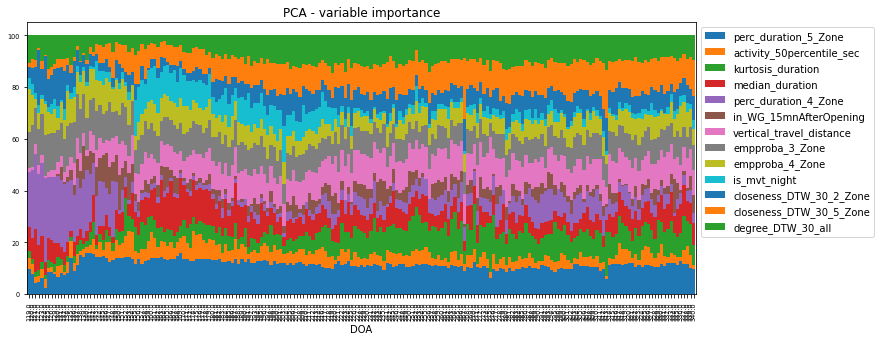

In [48]:
type_ = 'DOA'
n_components = 2

li_df = []
df = df_daily[li_lda+['HenID','level',type_]].copy()
print(df.shape)
df = df[~df.isnull().any(axis=1)]
print(df.shape)
#scaling numerical data: necessary due to duration high values
sc = StandardScaler()
df[li_lda] = sc.fit_transform(df[li_lda])
display(df[['HenID','level',type_]+li_lda].head(3))
for woa in df[type_].unique():
    df_ = df[df[type_]==woa].copy()
    pca = PCA(n_components=n_components)
    X = df_[li_lda]
    pca.fit(X)
    X = pca.transform(X)
    #pca.components_ has shape [n_components, n_features]
    df_pca = pd.DataFrame(pca.components_, columns=li_lda)
    df_pca['component_importance'] = pca.explained_variance_ratio_
    dico_ = {type_:woa,'sum_explained_var': sum(pca.explained_variance_ratio_), 'n_components':n_components}
    for v in li_lda:
        dico_[v] = sum(df_pca['component_importance']*abs(df_pca[v]))
    li_df.append(dico_)
df_pca = pd.DataFrame(li_df)
print(df_pca.shape)
display(df_pca.head(3))

#visualisei
df_plot_normalized = df_pca[li_lda+[type_]].set_index(type_)
df_plot_normalized = df_plot_normalized.div(df_plot_normalized.sum(axis=1)/100, axis=0)
df_plot_normalized = df_plot_normalized.sort_values([type_])
#display(df_plot_normalized.head(3))
#df_plot.plot(kind='bar',stacked=True);
df_plot_normalized.plot(kind='bar', width=1, stacked=True, figsize=(12,5), fontsize=6.5)
#change legend position
plt.legend(bbox_to_anchor=(1, 1))
plt.title('PCA - variable importance')
plt.savefig(os.path.join(path_extracted_data_visual_pca,type_+'_VariableImportance.png'), bbox_inches='tight', dpi=300)
plt.show();

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



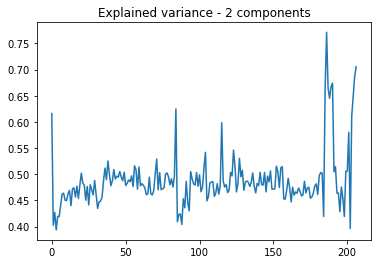

In [49]:
plt.plot(df_pca['sum_explained_var'].tolist());
plt.title('Explained variance - '+str(n_components)+' components')
plt.savefig(os.path.join(path_extracted_data_visual_pca,'ComponentsExplVar.png'), bbox_inches='tight', dpi=300)
plt.show()

In [50]:
df_daily[(df_daily['night_Total_number_transition']>3)][['DOA','level','PenID','HenID','night_Total_number_transition','duration_5_Zone',
                            'verification_daily_total_duration']].sort_values(['night_Total_number_transition'], ascending=False).head(5)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,DOA,level,PenID,HenID,night_Total_number_transition,duration_5_Zone,verification_daily_total_duration
5151,184.0,2020-12-04,9.0,hen_120,72.0,37832.0,54000.0
13801,330.0,2021-04-29,8.0,hen_158,47.0,593.0,54000.0
13792,321.0,2021-04-20,8.0,hen_158,46.0,302.0,54000.0
6058,234.0,2021-01-23,8.0,hen_124,44.0,3328.0,54000.0
31994,143.0,2020-10-24,8.0,hen_56,43.0,8429.0,43200.0


In [51]:
#from: https://plotly.com/python/pca-visualization/
df = df_daily[li_lda+['HenID','level',type_,'29-09 weight']].copy()
print(df.shape)
df = df[~df.isnull().any(axis=1)]
print(df.shape)
X = df[li_lda]

pca = PCA(n_components=2)
components = pca.fit_transform(X)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig = px.scatter(components, x=0, y=1, color=df['29-09 weight']) #HenID

for i, feature in enumerate(li_lda):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1]
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )
plt.savefig(os.path.join(path_extracted_data_visual_pca, 'PCA.png'), dpi=300, format='png', bbox_inches='tight')
fig.show()
#magnitude is the importance of the feature

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



(42300, 17)
(22248, 17)


<Figure size 432x288 with 0 Axes>

# LDA - linear discrimnant analysis

In [52]:
df = df_daily[li_lda+['HenID','level']].copy()
print(df.shape)
df = df[~df.isnull().any(axis=1)]
print(df.shape)
#scaling numerical data: necessary due to duration high values; input variables have differing units or scales
sc = StandardScaler()
df[li_lda] = sc.fit_transform(df[li_lda])
display(df[['HenID','level']+li_lda].head(3))

(42300, 15)
(29603, 15)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,HenID,level,perc_duration_5_Zone,activity_50percentile_sec,kurtosis_duration,median_duration,perc_duration_4_Zone,in_WG_15mnAfterOpening,vertical_travel_distance,empproba_3_Zone,empproba_4_Zone,is_mvt_night,closeness_DTW_30_2_Zone,closeness_DTW_30_5_Zone,degree_DTW_30_all
1,hen_1,2020-10-01,1.001854,-0.319627,-0.299151,3.201689,-1.159840,-0.481952,-1.673580,-0.032467,0.563701,-0.52404,1.033484,0.609112,1.901321
29,hen_1,2020-10-31,1.636401,0.258200,0.235102,1.341045,-0.706102,-0.481952,-1.673580,0.618333,1.624791,-0.52404,0.226357,-2.165757,-1.055133
30,hen_1,2020-11-01,1.524569,1.389128,1.673861,-0.113055,0.700977,-0.481952,-0.840436,1.187783,1.018454,-0.52404,1.051103,-0.128093,-0.699487


In [53]:
X = df[li_lda].values
y = df['HenID'].values
print(X.shape, y.shape)
df[li_lda][df[li_lda].isnull().sum(axis=1)>1]

(29603, 13) (29603,)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,perc_duration_5_Zone,activity_50percentile_sec,kurtosis_duration,median_duration,perc_duration_4_Zone,in_WG_15mnAfterOpening,vertical_travel_distance,empproba_3_Zone,empproba_4_Zone,is_mvt_night,closeness_DTW_30_2_Zone,closeness_DTW_30_5_Zone,degree_DTW_30_all


In [54]:
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
lda.fit(X, y)
#extract the labels
li_labels = lda.classes_
print(li_labels[0:10])
#defined nbr components to analyse
nbr_lda_components = 4

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

C:\Users\camil\anaconda3\lib\site-packages\sklearn\covariance\_empirical_covariance.py:88: UserWarning:

Only one sample available. You may want to reshape your data array



['hen_1' 'hen_10' 'hen_100' 'hen_101' 'hen_102' 'hen_103' 'hen_104'
 'hen_105' 'hen_106' 'hen_107']


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



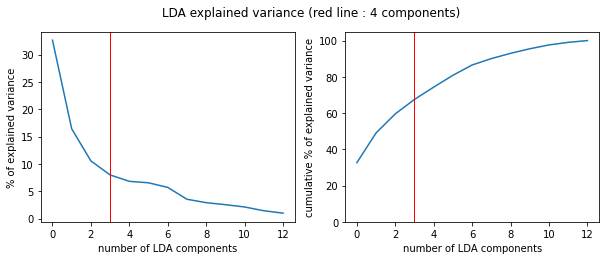

We have 221 hens, 29603 observations (~133 per class), 13 expl. variables 
(221, 13) (221, 13)
(13, 13)
(13,)


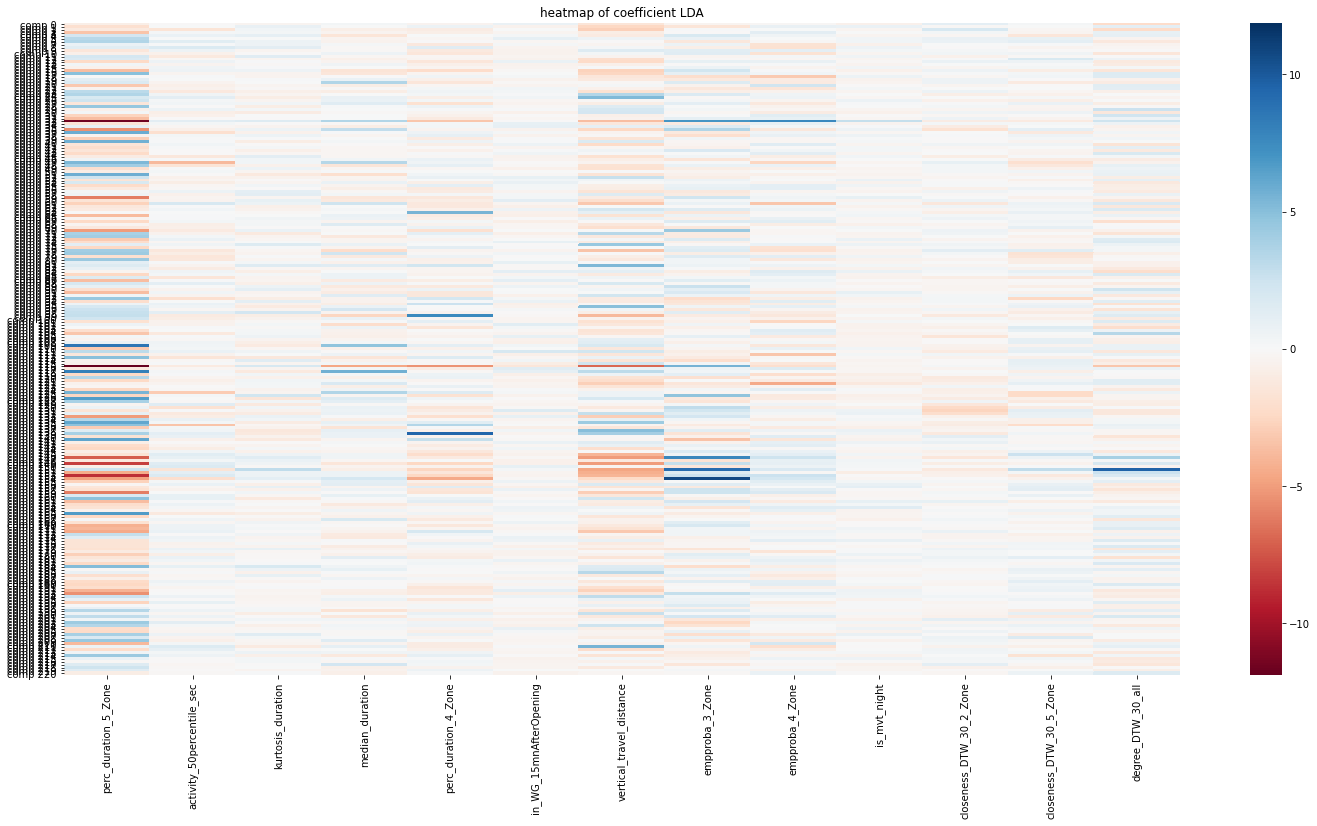

(4, 13)


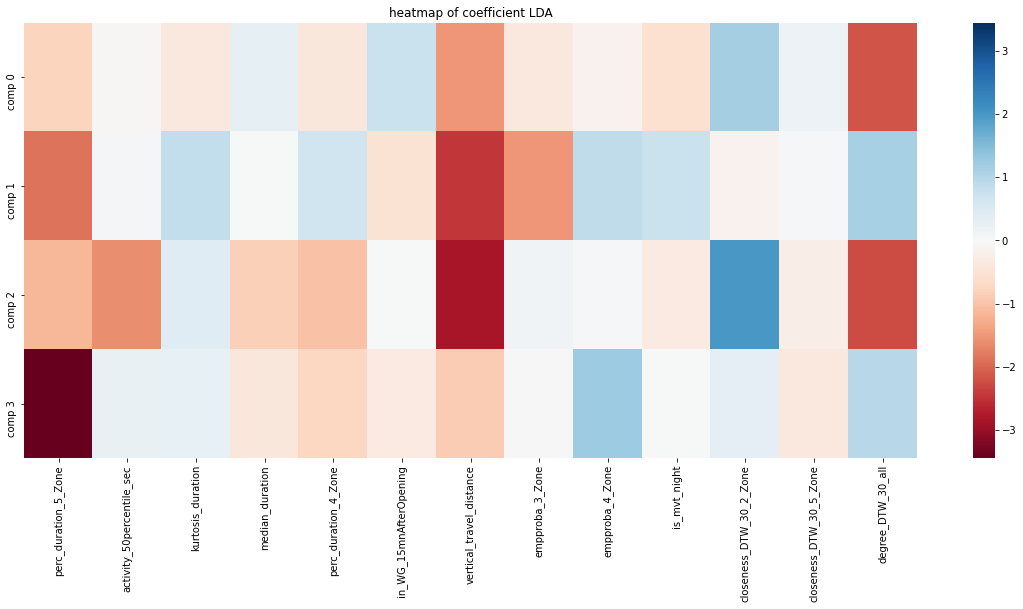

In [55]:
#Hens into the LDA 2Dspace
X_lda_sklearn = lda.transform(X)
#plot with the first two components
#plot_scikit_lda(X_lda_sklearn, y, lda, 'LDA_2comp', path_extracted_data_visual_lda)

#save it
'''dico_h_dinfo = {}
for h in set(y):
    for day_ in range(sum(y==h)):
        name_ = h+'_day_'+str(day_)
        if name_ not in dico_h_dinfo:
            dico_h_dinfo[name_] = {'HenID':h,'day':dico_hen_dates[h][day_]}
        for i in range(nbr_lda_components):
            dico_h_dinfo[name_]['ID'+str(i)] = list(X_lda_sklearn[:,i][y==h])[day_]
df_IDS = pd.DataFrame(list(dico_h_dinfo.values()))
#df_IDS['max_severity'] = df_IDS['HenID'].map(lambda x: dico_h_ms[x])
print(df_IDS.shape, df.shape)
df_IDS = pd.merge(df_IDS, df.filter(li_output+['HenID','day']),on=['HenID','day'],how='inner')
#df_IDS.to_csv(os.path.join(path_extracted_data_cleaning_rawvscleaned_LDA,'df_IDS_onall.csv'), index=False, sep=';')
print(df_IDS.shape)
display(df_IDS.head(3))'''

#LDA comp explained variance
explained_var(lda, nbr_lda_components, path_extracted_data_visual_lda)

#LDA component & Expl. var
#small info on input/ouput shape
print('We have %d hens, %d observations (~%d per class), %d expl. variables '%(len(set(y)), 
                                                                               X.shape[0], X.shape[0]/len(set(y)),
                                                                               X.shape[1]))
#for each hen we have the coefficient/mean linked to each expl. variables
print(lda.coef_.shape, lda.means_.shape)
#for each expl. variables we have a row/column in the cov matrix
print(lda.covariance_.shape)
#for each of the n_components we have the explained_variance_ratio (by default its the min(n_classes - 1, n_features))
print(lda.explained_variance_ratio_.shape)

#for each of the lda components its link to the associated variables (50,54). Lets do a heatmap of the coefficient strength
plt.figure(figsize=(25,12))
M = lda.coef_
v = max(abs(M.min()),M.max())
sns.heatmap(M, xticklabels=li_lda, yticklabels=['comp '+str(i) for i in range(lda.coef_.shape[0])],
            vmin=-v, vmax=v, cmap="RdBu")
plt.title('heatmap of coefficient LDA')
#plt.savefig(os.path.join(path_extracted_data_cleaning_rawvscleaned_LDA, 'heatmap_coefficient_LDA_all_comp.png'),dpi=300,format='png',bbox_inches='tight')
plt.show()

#for each of the lda components its link to the associated variables (50,54). Lets do a heatmap of the coefficient strength
plt.figure(figsize=(20,8))
M = lda.coef_
M = M[0:nbr_lda_components,:]
print(M.shape)
v = max(abs(M.min()),M.max())
sns.heatmap(M, xticklabels=li_lda, yticklabels=['comp '+str(i) for i in range(M.shape[0])], vmin=-v, vmax=v, cmap="RdBu")
plt.title('heatmap of coefficient LDA')
plt.savefig(os.path.join(path_extracted_data_visual_lda, 'heatmap_coefficient_LDA_first_comp.png'), dpi=300, format='png', 
            bbox_inches='tight')
plt.show()

# Other option to be checked

In [ ]:
model = Isomap(n_components=2)
proj = model.fit_transform(df[li_lda])
plt.plot(proj[:, 0], proj[:, 1], 'o');